## <div align="center"> UJIAN AKHIR SEMESTER IF540-L MACHINE LEARNING </div>
## <div align="center"> Semester Gasal 2024/2025 </div>
## <div align="center"> Penerapan Deep Learning untuk Deteksi Penipuan Transaksi Kartu Kredit Menggunakan RNN
 </div>

---
## Instruction

<ul>
    <li>Please make sure that <b>ALL</b> required submission files are submitted on the E-Learning.</li>
    <li>Please make sure to use <b>Markdown</b> as comment for the code you are writing</li>
    <li>Do not ZIP the submission files</li>
</ul>

## Caution
<ul>
    <li>We DOES NOT ACCEPT a submission via Gmail, Google Drive, Whatsapp, or any other than E-Learning</li>
    <li>We DOES NOT tolerate any plagriarism, etc.</li>
    <li>DO NOT change the order of this template.</li>
</ul>

---
### Group 6

##### Members : 
<ul>
    <li>1. Khalif Ziran Maulana - 00000071749</li>
    <li>2. Muhammad Ravindra Mahesandra - 00000072501</li>
    <li>3. Vinsensius Paulo Ryananda Virgiawan - 00000073384</li>
    <li>4. Daniel Ricardo Hadirahardja - 00000071936</li>
</ul>

---



### The dataset that are being used for the project

1. Credit Card Fraud Detection – Source : https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data

### Dataset Description: 
##### Please describe the dataset with much detail if possible
Dataset ini merupakan kumpulan data transaksi kartu kredit yang digunakan untuk membangun model deteksi penipuan. Dataset terdiri dari sejumlah fitur yang telah melalui proses reduksi dimensi menggunakan PCA (untuk fitur V1 - V28) dan beberapa fitur tambahan seperti time dan amount. Dataset ini sangat tidak seimbang karena hanya sekitar 0.17% dari transaksi adalah penipuan (class = 1), yang mencerminkan kejadian sebenarnya dalam dunia nyata di mana penipuan jauh lebih sedikit dibandingkan transaksi yang sah.

- Time: Menyatakan jumlah detik yang berlalu antara transaksi ini dan transaksi pertama dalam dataset. - V1 - V28: Hasil dari reduksi dimensi menggunakan Principal Component Analysis (PCA). Transformasi ini dilakukan untuk melindungi identitas pengguna dan mengurangi sensitivitas fitur asli, yang mungkin mengandung data pribadi. V1 hingga V28 merupakan fitur-fitur yang mewakili informasi penting terkait transaksi setelah reduksi dimensi
- Amount: Jumlah nominal transaksi yang terjad
- 
Class: Label target yang menyatakan apakah transaksi tersebut merupakan penipuan (1) atau bukan (0). Ini adalah variabel target yang akan diprediksi oleh model

### Project Showcase

### IMPORT LIBRARY

In [92]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from tensorflow.keras.utils import plot_model

### PREPROCESSING
- Tahap preprocessing dimulai dengan memuat dataset transaksi kartu kredit dan mengurutkannya berdasarkan kolom Time untuk mempertahankan urutan waktu dari data.
- Selanjutnya, dilakukan pemeriksaan terhadap missing values pada setiap kolom dan memastikan bahwa tidak ada data yang hilang. Kemudian, distribusi variabel target (Class) dianalisis, menunjukkan bahwa dataset sangat tidak seimbang dengan hanya 0,17% transaksi yang merupakan penipuan.
- Data fitur dinormalisasi menggunakan metode StandardScaler agar skala semua fitur seragam. Untuk mengatasi ketidakseimbangan kelas, teknik SMOTE (Synthetic Minority Oversampling Technique) diterapkan untuk menghasilkan data sintetis dari kelas minoritas.
- Setelah itu, dataset hasil balancing diurutkan kembali berdasarkan kolom Time untuk mempertahankan sifat time series-nya.
- Terakhir, dataset diubah menjadi sekuensi time series menggunakan jendela data sepanjang 30 langkah, dengan setiap sekuensi dihubungkan dengan label targetnya.

#### 2. Muat Dataset dan Sort Data Berdasarkan Time 

In [93]:
data = pd.read_csv('creditcard.csv')
data = data.sort_values(by='Time').reset_index(drop=True)

#### 3. Check for missing values

In [94]:
print("Missing values per column:")
print(data.isnull().sum())

Missing values per column:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


#### 4. Check the distribution of the 'Class' variable

In [95]:
print("\nClass distribution:")
print(data['Class'].value_counts())


Class distribution:
Class
0    284315
1       492
Name: count, dtype: int64


#### 5. Normalisasi

In [96]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data.drop(columns=['Class']))
scaled_data = pd.DataFrame(scaled_features, columns=data.columns[:-1])
scaled_data['Class'] = data['Class']

#### 6. Balancing

In [97]:
X_rnn = scaled_data.drop(columns=['Class'])
y_rnn = scaled_data['Class']

smote = SMOTE(random_state=42)
X_balanced_rnn, y_balanced_rnn = smote.fit_resample(X_rnn, y_rnn)

#### 7. Buat dataframe seimbang dan urutkan ulang berdasarkan waktu

In [98]:
balanced_data_rnn = pd.DataFrame(X_balanced_rnn, columns=X_rnn.columns)
balanced_data_rnn['Class'] = y_balanced_rnn
balanced_data_rnn = balanced_data_rnn.sort_values(by='Time').reset_index(drop=True)

#### 8. Membuat sekuensi time series

In [99]:
def create_sequences(data, target_col, sequence_length=30):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i + sequence_length].drop(columns=[target_col]).values
        label = data.iloc[i + sequence_length][target_col]
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

# Membuat sekuensi time series
sequence_length = 30
X_seq_rnn, y_seq_rnn = create_sequences(balanced_data_rnn, target_col='Class', sequence_length=sequence_length)

### PEMBANGUNAN MODEL
- Model dikembangkan dengan membagi data time series menjadi data latih dan data uji, menggunakan rasio 80:20 dan stratifikasi untuk memastikan distribusi kelas tetap terjaga di setiap subset.
- Model RNN dibangun menggunakan arsitektur LSTM (Long Short-Term Memory) dengan dua lapisan utama. Lapisan pertama memiliki 32 unit dengan output sekuensial, dan lapisan kedua memiliki 16 unit tanpa output sekuensial. Dropout diterapkan di setiap lapisan untuk mencegah overfitting, diikuti dengan lapisan dense berisi 64 unit dengan fungsi aktivasi ReLU, dan lapisan output berisi 1 unit dengan fungsi aktivasi sigmoid untuk klasifikasi biner.
- Model di-compile menggunakan optimizer Adam dengan fungsi loss binary_crossentropy dan metrik akurasi. Pelatihan model dilakukan selama maksimal 20 epoch dengan batch size 200, menggunakan callback EarlyStopping untuk menghentikan pelatihan lebih awal jika performa pada data validasi tidak meningkat setelah tiga epoch berturut-turut.

#### 9. Split data menjadi train-test

In [100]:
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(
    X_seq_rnn, y_seq_rnn, test_size=0.2, random_state=42, stratify=y_seq_rnn
)

#### 10. Pembangunan model

In [101]:
rnn = Sequential()
rnn.add(LSTM(32, return_sequences=True, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]), dropout=0.3, recurrent_dropout=0.2))
rnn.add(LSTM(16, return_sequences=False, dropout=0.3, recurrent_dropout=0.2))
rnn.add(Dropout(0.4))
rnn.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
rnn.add(Dropout(0.5))
rnn.add(Dense(1, activation='sigmoid'))

C:\Users\Msi Gf63\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### 11. Compile model

In [102]:
rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#### 12. Train model dengan earlystopping

In [103]:
early_stopping_rnn = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_rnn = rnn.fit(
    X_train_rnn, y_train_rnn,
    epochs=20,
    batch_size=200,
    validation_data=(X_test_rnn, y_test_rnn),
    callbacks=[early_stopping_rnn],
    verbose=1
)

Epoch 1/20
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 42s 15ms/step - accuracy: 0.6538 - loss: 0.6538 - val_accuracy: 0.6999 - val_loss: 0.5633
Epoch 2/20
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.6937 - loss: 0.5740 - val_accuracy: 0.7047 - val_loss: 0.5568
Epoch 3/20
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 35s 15ms/step - accuracy: 0.6973 - loss: 0.5695 - val_accuracy: 0.7066 - val_loss: 0.5542
Epoch 4/20
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 36s 16ms/step - accuracy: 0.6989 - loss: 0.5670 - val_accuracy: 0.7065 - val_loss: 0.5534
Epoch 5/20
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 35s 15ms/step - accuracy: 0.6983 - loss: 0.5664 - val_accuracy: 0.7068 - val_loss: 0.5537
Epoch 6/20
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 36s 16ms/step - accuracy: 0.7014 - loss: 0.5644 - val_accuracy: 0.7077 - val_loss: 0.5525
Epoch 7/20
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 37s 16ms/step - accuracy: 0.7016 - loss: 0.5643 - val_accuracy: 0.7086 - val_loss: 0.5510
Epoch 8/20
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 35s 15ms/step - accuracy: 0.7011 -

### EVALUASI MODEL
- Model dievaluasi menggunakan data uji dengan menghasilkan prediksi probabilitas, yang kemudian diubah menjadi label biner berdasarkan threshold 0,5. Evaluasi performa melibatkan pembuatan confusion matrix, yang divisualisasikan dalam bentuk heatmap untuk memberikan gambaran distribusi prediksi benar dan salah.
- Selain itu, classification report dihasilkan untuk menilai metrik seperti precision, recall, dan F1-score pada kedua kelas. Akurasi keseluruhan model adalah sekitar 71%. Untuk memahami proses pelatihan model, visualisasi grafik akurasi dan loss dilakukan pada data latih dan validasi di setiap epoch.
- Hasil menunjukkan bahwa model berhasil belajar pola dari data, namun performanya masih dapat ditingkatkan dengan optimasi lebih lanjut, seperti tuning hyperparameter atau eksperimen dengan arsitektur yang lebih kompleks.

#### 13. Mebuat prediksi terhadap output

In [104]:
predictions_prob_rnn = rnn.predict(X_test_rnn)
threshold = 0.5
predictions_rnn = (predictions_prob_rnn > threshold).astype(int)

3554/3554 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step


#### 14. Confusion matrix


[RNN] Confusion Matrix:
 [[44515 12342]
 [20774 36089]]


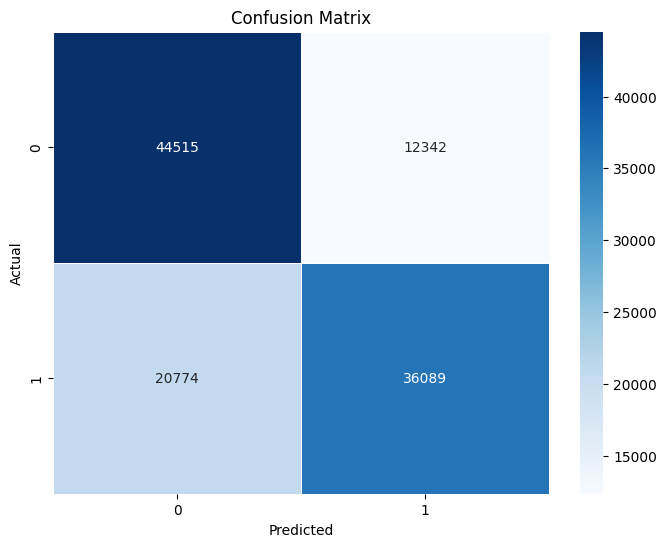

In [105]:
conf_matrix_rnn = confusion_matrix(y_test_rnn, predictions_rnn)
print("\n[RNN] Confusion Matrix:\n", conf_matrix_rnn)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rnn, annot=True, fmt="d", cmap="Blues", cbar=True, linewidths=0.5)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### 15. Klasifikasi report

In [106]:
print("\n[RNN] Classification Report:\n", classification_report(y_test_rnn, predictions_rnn))


[RNN] Classification Report:
               precision    recall  f1-score   support

         0.0       0.68      0.78      0.73     56857
         1.0       0.75      0.63      0.69     56863

    accuracy                           0.71    113720
   macro avg       0.71      0.71      0.71    113720
weighted avg       0.71      0.71      0.71    113720



#### 16. Visualisasi train accuracy

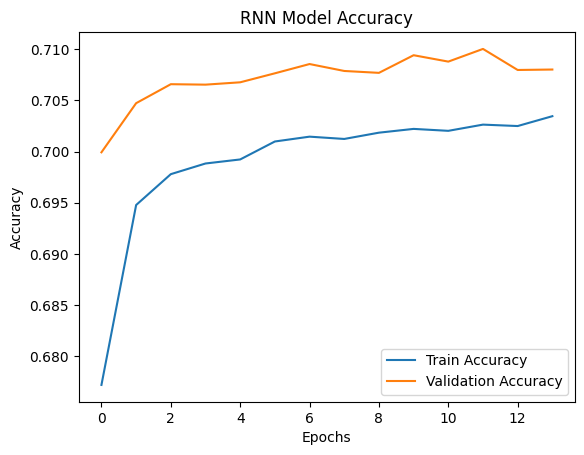

In [107]:
plt.plot(history_rnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title("RNN Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### 17. Visualisasi train lost

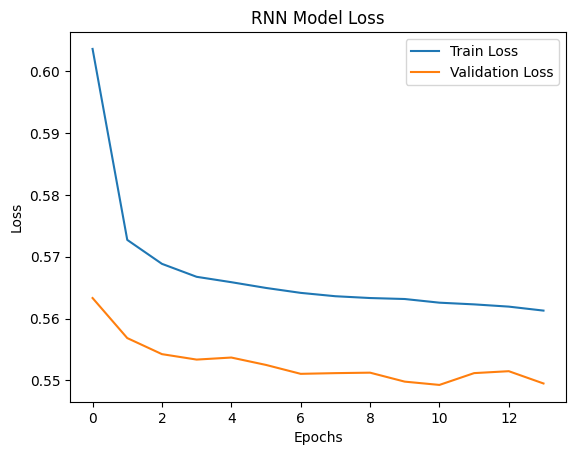

In [108]:
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title("RNN Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#### 18. Visualisasi model

In [109]:
rnn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 30, 32)         │         8,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,061 (144.77 KB)

 Trainable params: 12,353 (48.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 24,708 (96.52 KB)

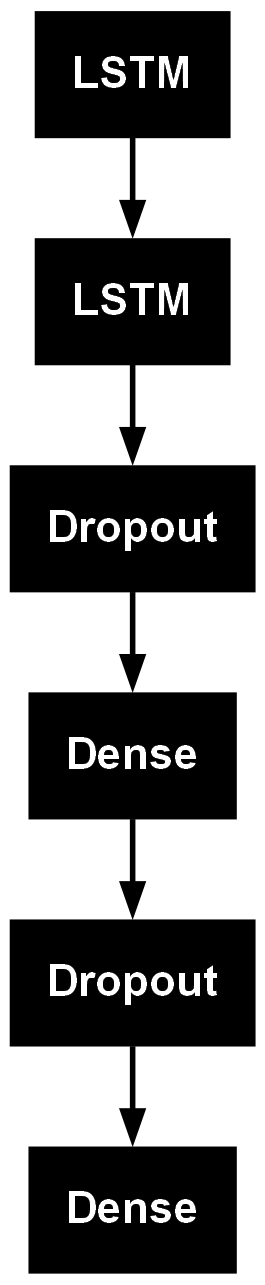

In [110]:
plot_model(rnn)

### Conclusion

<ul> <li>Model RNN yang dibangun menggunakan arsitektur LSTM berhasil mendeteksi pola dari data transaksi kartu kredit untuk membedakan antara transaksi penipuan dan transaksi yang sah.</li> <li>Penggunaan teknik SMOTE berhasil mengatasi ketidakseimbangan kelas, meningkatkan kemampuan model untuk mempelajari pola dari kelas minoritas.</li> <li>Model mencapai akurasi keseluruhan sebesar 71%, dengan performa yang cukup baik pada metrik precision, recall, dan F1-score untuk kedua kelas.</ul>

Secara keseluruhan, pendekatan berbasis deep learning ini menunjukkan potensi yang baik untuk diterapkan pada kasus nyata deteksi penipuan transaksi kartu kredit

In [114]:
!jupyter nbconvert --to html "./UTS2024_IF540L_KelasAL_Kelompok_6.ipynb" --output-dir="./"

[NbConvertApp] Converting notebook ./UTS2024_IF540L_KelasAL_Kelompok_6.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 420036 bytes to UTS2024_IF540L_KelasAL_Kelompok_6.html


### Next step:
* convert the generated html file to PDF using the online tool: https://www.sejda.com/html-to-pdf
* choose the following settings:
    * Page size: One long page
    * Page Orientation: auto
    * Use print stylesheet
* Submit your ipython notebook and PDF files

Markdown basics https://markdown-guide.readthedocs.io/en/latest/basics.html#